In [1]:
import pandas as pd
import numpy as np

try:
  # in google colab
  from cleaning import clean
  from tokenize_headlines import tokenize
  from word2vec import Word2Vec
except:
  from preprocessing.cleaning import clean
  from preprocessing.tokenize_headlines import tokenize
  from models.word2vec import Word2Vec


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
raw = pd.read_csv('civilnews-headlines-raw.csv')

In [3]:
clean = clean(raw)

In [4]:
clean['tokens'] = clean['headline'].apply(tokenize)

In [5]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34863 entries, 0 to 34862
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date-time  34863 non-null  datetime64[ns]
 1   headline   34863 non-null  object        
 2   views      34863 non-null  float64       
 3   tags       6630 non-null   object        
 4   tokens     34863 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 1.3+ MB


# Train-Test split

In [6]:
from sklearn.model_selection import train_test_split, cross_validate

In [7]:
train, test = train_test_split(clean, train_size = 0.5, shuffle = False)

# Word2Vec

In [8]:
word2vec = Word2Vec(epochs = 10)

In [9]:
word2vec.fit(train['tokens'])

Training started


  0%|          | 0/7730 [00:00<?, ?it/s]

  0%|          | 0/7730 [00:00<?, ?it/s]

  0%|          | 0/7730 [00:00<?, ?it/s]

  0%|          | 0/7730 [00:00<?, ?it/s]

  0%|          | 0/7730 [00:00<?, ?it/s]

  0%|          | 0/7730 [00:00<?, ?it/s]

  0%|          | 0/7730 [00:00<?, ?it/s]

  0%|          | 0/7730 [00:00<?, ?it/s]

  0%|          | 0/7730 [00:00<?, ?it/s]

  0%|          | 0/7730 [00:00<?, ?it/s]

Training finished
Model saved


In [10]:
train['embeddings'] = word2vec.predict(train['tokens'])

In [11]:
train.head()

,date-time,headline,views,tags,tokens,embeddings
0,1970-01-01 03:00:00,Medvedev Signs Cooperation Treaties with Sokhu...,7.0,NaN,"[medvedev, signs, cooperation, treaties, sokhu...","[[-0.19568232, 0.16354853, -0.049223147, 0.358..."
1,2001-07-05 18:15:00,Local Self-governance or just Governance?,14.0,NaN,"[local, self, governance, governance]","[[-0.1200304, 0.16232666, 0.55429745, 0.345847..."
2,2001-07-06 15:08:00,Secretary General of the Council of Europe mee...,6.0,NaN,"[secretary, general, council, europe, meets, g...","[[0.10055034, -0.1159299, -0.47734293, 0.23419..."
3,2001-07-06 15:51:00,Faction “Revival” Does Not Trust NGOs,5.0,NaN,"[faction, revival, trust, ngos]","[[0.23054646, 0.0163832, 0.18830794, 0.0722548..."
4,2001-07-06 16:21:00,OSCE Urges Russia to Leave the Gudauta Base,5.0,NaN,"[osce, urges, russia, leave, gudauta, base]","[[0.09099069, 0.18884778, -0.31387708, -0.1877..."


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


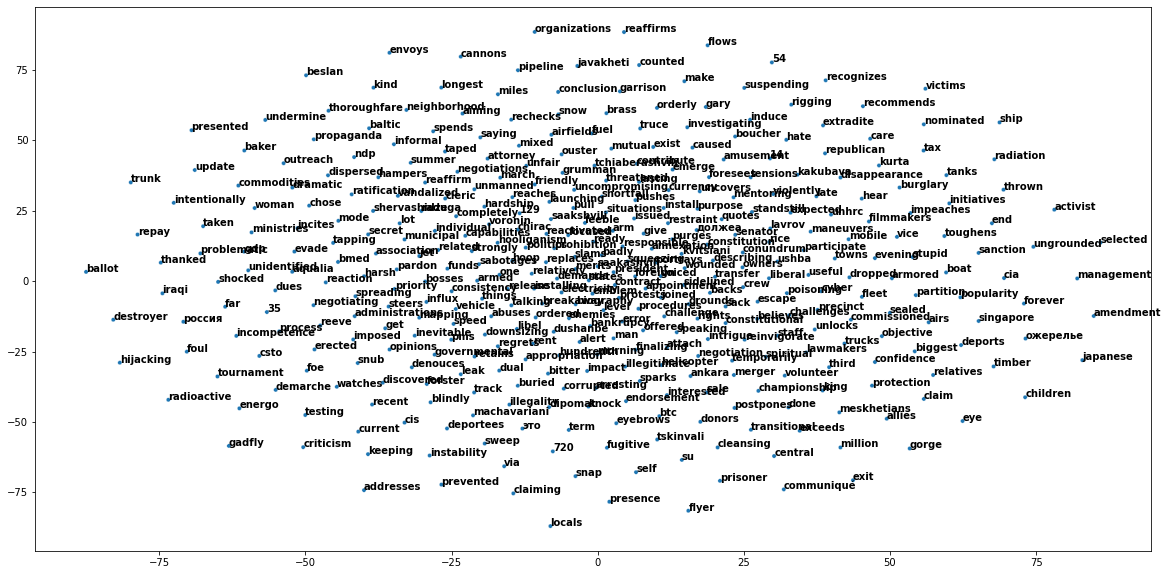

In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

word_embedding = dict(zip(train['tokens'].explode(), train['embeddings'].explode()))
word_embedding = pd.DataFrame.from_dict(word_embedding, orient = 'index').sample(400).reset_index()
tsne_df = tsne.fit_transform(word_embedding.loc[:, 1:])
import matplotlib.pyplot as plt
import seaborn as sns

def scatter_text():
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1],  size = 8, legend=False)
    # Add text besides each point
    for line in range(0, len(tsne_df)):
         p1.text(tsne_df[line, 0]+0.01, tsne_df[line, 1], 
                 word_embedding['index'][line], horizontalalignment='left', 
                 size='medium', color='black', weight='semibold')
    return p1

plt.figure(figsize=(20,10))
scatter_text()

# Predict views from headlines

## Averaging over headline embeddings - fails
The feature does not seem to be predictive of views


In [13]:
train['average_embeddings'] = train['embeddings'].apply(np.mean)

In [14]:
train['average_embeddings']

0       -0.007033
1       -0.015462
2        0.001408
3        0.012230
4        0.004653
           ...   
17426    0.013321
17427    0.005402
17428   -0.000270
17429   -0.005519
17430   -0.000417
Name: average_embeddings, Length: 17431, dtype: float32

In [15]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [16]:
xgbr = XGBRegressor()
X, y = pd.DataFrame(train['average_embeddings']), train['views']

In [17]:
xgbr.fit(X, y)

[09:38:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


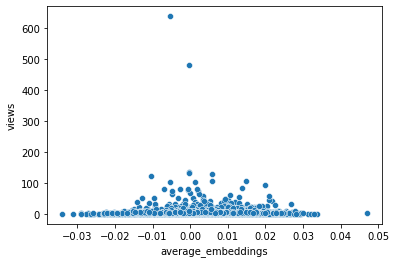

In [22]:
import seaborn as sns

sns.scatterplot(X.average_embeddings, y)
cross_val_score(xgbr, X, y)

# Time Series Analysis

In [45]:
train = train.loc[1:, :].reset_index(drop = True)

views_over_time = train[['date-time', 'views']].groupby(by = 'date-time').sum()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(730673.5451388889, 733264.9777777778)

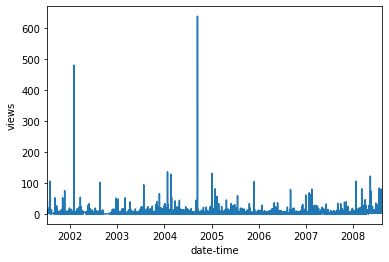

In [46]:
ax = sns.lineplot(views_over_time.index, views_over_time['views'])

ax.set_xlim(train['date-time'].min(), train['date-time'].max())